In [1005]:
# !pip install openpyxl

# Insurance Final Project - Solvency II

$\textit{MSc Mathematical Engineering - Track Quantitative Finance}$, $\textbf{Politecnico di Milano}$.

$\textit{Noé Debrois}$ \&$\textit{Vincent Haïk Karakoseian}$, $\textbf{March-April 2024}$.

### Step 0 : Import the libraries

In [1006]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step 1 : Simulate the fund made of 80% equity and 20% property using GBM :

Risk Neutral Geometric Brownian motion (GBM) S is defined by S0 > 0 and the dynamics as defined in the following Stochastic Differential Equation (SDE):


$\Large dS_t = r_t S_t dt + \sigma S_t dW_t$

Integrated Form:

 - $\log S_t = \log S_0 + \int_{0}^{t} (r_t-\frac{\sigma^2}{2}) \,ds + \int_{0}^{t} \sigma \,dW_s $

 - i.e : $\log S_t = \log S_0 + (r_t-\frac{\sigma^2}{2})t + \sigma W_t $

 - i.e : $\log S_t \sim N(\log S_0 + (r_t-\frac{\sigma^2}{2})t, \sigma^2 t)$

Explicit Expression:

$\Large S_t = S_0 {\rm e}^{(r_t-\frac{\sigma^2}{2})t + \sigma W_t}$

With $r_t$ being derived from RFR EIOPA withou VA. It is imported below.

In [1007]:
# Path to your Excel file
file_path = 'EIOPA_RFR_20240229_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="S", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA IT without VA, FEB'})
rt = np.array(df).T
rt = np.array(rt, np.float64)

#### Function to simulate Risk Neutral GBM paths :

In [1008]:
def simulate_gbm(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC,N))
    S[:,0] = np.full(m_MC, F0)
    for iter in range(m_MC):
        for t in range(1, N):
            # Generate random normal variable
            z = np.random.normal()
            # Update the stock price
            S[iter,t] = S[iter,t-1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

#### Fix the parameters for the simulation :

In [1009]:
# Parameters
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
F0 = 100000 # Initial value of the fund
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
rt = rt[0, :N] # Time-varying risk-free rate
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

#### Simulation :

In [1010]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt

#### Plot the value of our portfolio vs time :

(50, 100)(50, 100)


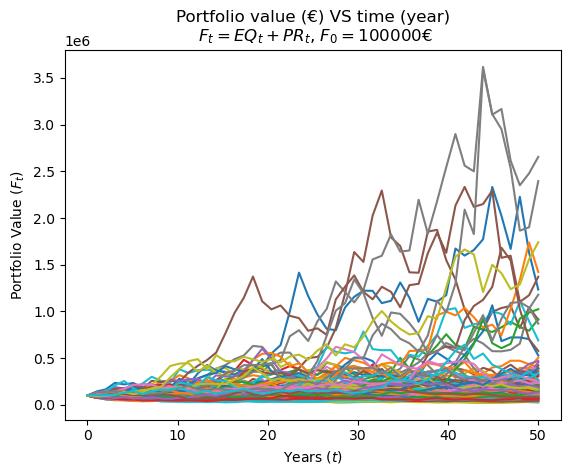

In [1011]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as Ft
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()

In [1026]:
def EQ_Shock(F0, rt, sigma_equity, dt, N, m_MC, shock):
    """
    - F0, rt, sigma_equity, dt, N, m_MC
    - shock : valeur du choc, = 1 - 0.39 (Type I)
    """
    EQt_sim = simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
    EQt_sim_shocked = EQt_sim * shock
    return EQt_sim, EQt_sim_shocked

def PR_Shock(F0, rt, sigma_property, dt, N, m_MC, shock):
    """
    - F0, rt, sigma_equity, dt, N, m_MC
    - shock : valeur du choc
    """
    PRt_sim = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)
    PRt_sim_shocked = PRt_sim * shock
    return PRt_sim, PRt_sim_shocked

def Simulate_ptf_IR(F0, r, sigma, dt, N, m_MC, PR_weight, EQ_weight, stress):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process

    # Generate stressed rates :
    r_up = r + min(0.01, stress * r)
    r_dw = r - stress * r

    # EQt :
    EQt = np.zeros((m_MC, N))
    EQt[:, 0] = np.full(m_MC, F0)

    EQt_up = np.zeros((m_MC, N))
    EQt_up[:, 0] = np.full(m_MC, F0)

    EQt_dw = np.zeros((m_MC, N))
    EQt_dw[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z_EQ = np.random.normal(size=m_MC)
        # Update the equity :
        EQt[:, t] = EQt[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_EQ)
        EQt_up[:, t] = EQt_up[:, t - 1] * np.exp((r_up[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_EQ)
        EQt_dw[:, t] = EQt_dw[:, t - 1] * np.exp((r_dw[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_EQ)

    # PRt :
    PRt = np.zeros((m_MC, N))
    PRt[:, 0] = np.full(m_MC, F0)

    PRt_up = np.zeros((m_MC, N))
    PRt_up[:, 0] = np.full(m_MC, F0)

    PRt_dw = np.zeros((m_MC, N))
    PRt_dw[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z_PR = np.random.normal(size=m_MC)
        # Update the equity :
        PRt[:, t] = PRt[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_PR)
        PRt_up[:, t] = PRt_up[:, t - 1] * np.exp((r_up[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_PR)
        PRt_dw[:, t] = PRt_dw[:, t - 1] * np.exp((r_dw[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_PR)

    # Generate ptfs :
    ptf = PR_weight * PRt + EQ_weight * EQt
    ptf_IR_up = PR_weight * PRt_up + EQ_weight * EQt_up
    ptf_IR_dw = PR_weight * PRt_dw + EQ_weight * EQt_dw
    return ptf, ptf_IR_dw, ptf_IR_up

def Build_EQ_PR_shocked_ptf(EQt, EQt_shocked, PRt, PRt_shocked, PR_weight, EQ_weight):
    """
    Construit un ptf normal et les shocked ptf
    """
    ptf_EQ_shocked = EQ_weight * EQt_shocked + PR_weight * PRt
    ptf_PR_shocked = EQ_weight * EQt + PR_weight * PRt_shocked
    ptf = EQ_weight * EQt + PR_weight * PRt
    return ptf, ptf_EQ_shocked, ptf_PR_shocked

def Loss_IR(ptf, ptf_up, ptf_down):
    loss_down = ptf_down - ptf # <0 : il y a une perte !
    loss_up = ptf_up - ptf
    return loss_down, loss_up

def Loss_PR_EQ(ptf, ptf_shocked):
    loss = ptf_shocked - ptf
    return loss

In [1016]:
z = np.random.normal(0, 1, 10)
z

array([ 2.44129131,  1.36407533,  0.55230158, -1.71748837, -0.15086938,
        0.58449463,  0.30024377,  0.20593658, -0.72929217,  0.0917095 ])

In [1020]:
np.quantile(z, 0.995) # 99.5 th quantile

2.392816592248223

In [1019]:
np.median(z)

0.2530901761490946

TEST

In [1028]:
EQ, EQt_Shock = EQ_Shock(F0, rt, sigma_equity, dt, N, m_MC, 0.5)
PR, PRt_Shock = PR_Shock(F0, rt, sigma_property, dt, N, m_MC, 0.5)

In [1029]:
Ptf, Ptf_EQ_Shock, Ptf_PR_Shock = Build_EQ_PR_shocked_ptf(EQ, EQt_Shock, PR, PRt_Shock, PR_weight, EQ_weight)

In [1031]:
Loss_EQ = Loss_PR_EQ(Ptf, Ptf_EQ_Shock)
Loss_PR = Loss_PR_EQ(Ptf, Ptf_PR_Shock)

In [1034]:
Loss_EQ

array([[  -40000.        ,   -34109.11069754,   -31416.64369155, ...,
         -922133.36114496,  -642584.7755228 ,  -594618.15975468],
       [  -40000.        ,   -38368.15758057,   -34081.19411693, ...,
          -48544.73556272,   -51609.20203459,   -45028.28347178],
       [  -40000.        ,   -37796.91397124,   -33146.85436421, ...,
         -232217.53088693,  -338235.52073196,  -377405.58034258],
       ...,
       [  -40000.        ,   -52777.73284016,   -65836.86365274, ...,
         -875834.5811666 , -1030905.1518152 ,  -790505.48471925],
       [  -40000.        ,   -42792.35700015,   -46547.68171708, ...,
          -22685.17936008,   -20015.76964662,   -22463.52310638],
       [  -40000.        ,   -45727.33979456,   -43644.41971035, ...,
          -91965.69430496,   -84207.77128636,   -73231.07338849]])

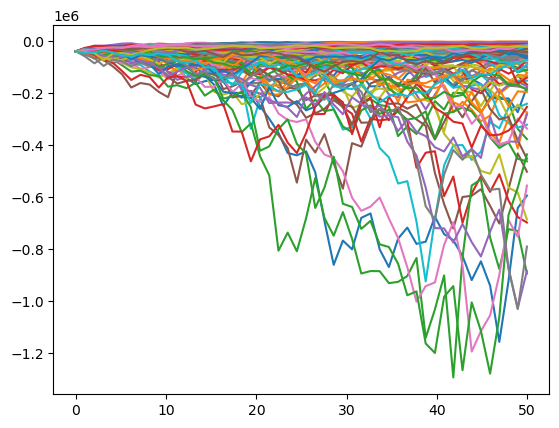

In [1035]:
plt.plot(tt, Loss_EQ.T);